In [108]:
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor 
from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
train_df = pd.read_csv('data/train_all_v4.csv', index_col='Unnamed: 0')
val_df = pd.read_csv('data/val_all_v4.csv', index_col='Unnamed: 0')

In [187]:
# ecols = [c for c in train_df.columns if 'Unnamed' not in c]
# ecols
# train_df[ecols].to_csv('data/train_all_v4.csv')
# val_df[ecols].to_csv('data/val_all_v4.csv')

In [191]:
train_df.head()

,ip_ddos_0,er_ddos_0,out_ddos_0,snf_ddos_0,icf_ddos_0,hh_ddos_0,amb_ddos_0,hsp_ddos_0,pro_ddos_0,spc_fac_ddos_0,dme_ddos_0,cls_ddos_0,hha_ddos_0,ip_ddos_1,er_ddos_1,out_ddos_1,snf_ddos_1,icf_ddos_1,hh_ddos_1,amb_ddos_1,hsp_ddos_1,pro_ddos_1,spc_fac_ddos_1,dme_ddos_1,cls_ddos_1,hha_ddos_1,ip_ddos_2,er_ddos_2,out_ddos_2,snf_ddos_2,icf_ddos_2,hh_ddos_2,amb_ddos_2,hsp_ddos_2,pro_ddos_2,spc_fac_ddos_2,dme_ddos_2,cls_ddos_2,hha_ddos_2,ip_ddos_3,er_ddos_3,out_ddos_3,snf_ddos_3,icf_ddos_3,hh_ddos_3,amb_ddos_3,hsp_ddos_3,pro_ddos_3,spc_fac_ddos_3,dme_ddos_3,cls_ddos_3,hha_ddos_3,ip_ddos_4,er_ddos_4,out_ddos_4,snf_ddos_4,icf_ddos_4,hh_ddos_4,amb_ddos_4,hsp_ddos_4,pro_ddos_4,spc_fac_ddos_4,dme_ddos_4,cls_ddos_4,hha_ddos_4,ip_ddos_5,er_ddos_5,out_ddos_5,snf_ddos_5,icf_ddos_5,hh_ddos_5,amb_ddos_5,hsp_ddos_5,pro_ddos_5,spc_fac_ddos_5,dme_ddos_5,cls_ddos_5,hha_ddos_5,ip_ddos_6,er_ddos_6,out_ddos_6,snf_ddos_6,icf_ddos_6,hh_ddos_6,amb_ddos_6,hsp_ddos_6,pro_ddos_6,spc_fac_ddos_6,dme_ddos_6,cls_ddos_6,hha_ddos_6,ip_ddos_7,er_ddos_7,out_ddos_7,snf_ddos_7,icf_ddos_7,hh_ddos_7,amb_ddos_7,hsp_ddos_7,pro_ddos_7,spc_fac_ddos_7,dme_ddos_7,cls_ddos_7,hha_ddos_7,ip_ddos_8,er_ddos_8,out_ddos_8,snf_ddos_8,icf_ddos_8,hh_ddos_8,amb_ddos_8,hsp_ddos_8,pro_ddos_8,spc_fac_ddos_8,dme_ddos_8,cls_ddos_8,hha_ddos_8,ip_ddos_9,er_ddos_9,out_ddos_9,snf_ddos_9,icf_ddos_9,hh_ddos_9,amb_ddos_9,hsp_ddos_9,pro_ddos_9,spc_fac_ddos_9,dme_ddos_9,cls_ddos_9,hha_ddos_9,ip_ddos_10,er_ddos_10,out_ddos_10,snf_ddos_10,icf_ddos_10,hh_ddos_10,amb_ddos_10,hsp_ddos_10,pro_ddos_10,spc_fac_ddos_10,dme_ddos_10,cls_ddos_10,hha_ddos_10,ip_ddos_11,er_ddos_11,out_ddos_11,snf_ddos_11,icf_ddos_11,hh_ddos_11,amb_ddos_11,hsp_ddos_11,pro_ddos_11,spc_fac_ddos_11,dme_ddos_11,cls_ddos_11,hha_ddos_11,hcbs_attdpcs_tc_0,hcbs_other_tc_0,hcbs_support_house_tc_0,hcbs_adult_day_tc_0,hcbs_pers_tc_0,hcbs_assist_tech_tc_0,oxygen_tc_0,hosp_bed_tc_0,chf_tc_0,heart_tc_0,copd_tc_0,pulmonar_tc_0,cancer_tc_0,ckd_tc_0,esrd_tc_0,lipidy_tc_0,diab_tc_0,alzh_tc_0,demented_tc_0,stroke_tc_0,hyper_tc_0,fall_tc_0,trans_tc_0,liver_tc_0,hippy_tc_0,depressed_tc_0,psycho_tc_0,druggy_tc_0,boozy_tc_0,paralyzed_tc_0,mono_tc_0,mono_dom_tc_0,hemi_tc_0,hemi_dom_tc_0,para_tc_0,quad_tc_0,tbi_tc_0,obese_tc_0,pressure_ulcer_tc_0,hemophilia_tc_0,hcbs_attdpcs_tc_1,hcbs_other_tc_1,hcbs_support_house_tc_1,hcbs_adult_day_tc_1,hcbs_pers_tc_1,hcbs_assist_tech_tc_1,oxygen_tc_1,hosp_bed_tc_1,chf_tc_1,heart_tc_1,copd_tc_1,pulmonar_tc_1,cancer_tc_1,ckd_tc_1,esrd_tc_1,lipidy_tc_1,diab_tc_1,alzh_tc_1,demented_tc_1,stroke_tc_1,hyper_tc_1,fall_tc_1,trans_tc_1,liver_tc_1,hippy_tc_1,depressed_tc_1,psycho_tc_1,druggy_tc_1,boozy_tc_1,paralyzed_tc_1,mono_tc_1,mono_dom_tc_1,hemi_tc_1,hemi_dom_tc_1,para_tc_1,quad_tc_1,tbi_tc_1,obese_tc_1,pressure_ulcer_tc_1,hemophilia_tc_1,hcbs_attdpcs_tc_2,hcbs_other_tc_2,hcbs_support_house_tc_2,hcbs_adult_day_tc_2,hcbs_pers_tc_2,hcbs_assist_tech_tc_2,oxygen_tc_2,hosp_bed_tc_2,chf_tc_2,heart_tc_2,copd_tc_2,pulmonar_tc_2,cancer_tc_2,ckd_tc_2,...,depressed_tc_6,psycho_tc_6,druggy_tc_6,boozy_tc_6,paralyzed_tc_6,mono_tc_6,mono_dom_tc_6,hemi_tc_6,hemi_dom_tc_6,para_tc_6,quad_tc_6,tbi_tc_6,obese_tc_6,pressure_ulcer_tc_6,hemophilia_tc_6,hcbs_attdpcs_tc_7,hcbs_other_tc_7,hcbs_support_house_tc_7,hcbs_adult_day_tc_7,hcbs_pers_tc_7,hcbs_assist_tech_tc_7,oxygen_tc_7,hosp_bed_tc_7,chf_tc_7,heart_tc_7,copd_tc_7,pulmonar_tc_7,cancer_tc_7,ckd_tc_7,esrd_tc_7,lipidy_tc_7,diab_tc_7,alzh_tc_7,demented_tc_7,stroke_tc_7,hyper_tc_7,fall_tc_7,trans_tc_7,liver_tc_7,hippy_tc_7,depressed_tc_7,psycho_tc_7,druggy_tc_7,boozy_tc_7,paralyzed_tc_7,mono_tc_7,mono_dom_tc_7,hemi_tc_7,hemi_dom_tc_7,para_tc_7,quad_tc_7,tbi_tc_7,obese_tc_7,pressure_ulcer_tc_7,hemophilia_tc_7,hcbs_attdpcs_tc_8,hcbs_other_tc_8,hcbs_support_house_tc_8,hcbs_adult_day_tc_8,hcbs_pers_tc_8,hcbs_assist_tech_tc_8,oxygen_tc_8,hosp_bed_tc_8,chf_tc_8,heart_tc_8,copd_tc_8,pulmonar_tc_8,cancer_tc_8,ckd_tc_8,esrd_tc_8,lipidy_tc_8,diab_tc_8,alzh_tc_8,demented_tc_8,stroke_tc_8,hyper_tc_8,fall_tc_8,

### Training Experiements

#### Kitchen sink of features
Month over month tc and ddos and categorical

In [192]:
x_cols = [c for c in train_df.columns if c not in ['member_id', 'target', 'period']]
# x_cols = [c for c in training_df.columns if c not in ['member_id', 'target', 'period'] + cat_feats]
x = train_df[x_cols]
y = train_df.target

In [193]:
ridge = Ridge(alpha=1, normalize=True)
ridge.fit(x, y)
ridge.score(x,y)

0.14424797162605385

In [194]:
val_x = val_df[x_cols]
val_y = val_df.target
ridge.score(val_x,val_y)

0.13751398796161485

In [195]:
histr = HistGradientBoostingRegressor()
histr.fit(x, y)

HistGradientBoostingRegressor()

In [196]:
histr.score(x, y)

0.2552164363200292

In [197]:
histr.score(val_x, val_y)

0.14475870961046677

In [119]:
preds = histr.predict(val_x)
actual_predicted_df = pd.DataFrame(zip(val_y.values, preds, np.abs(val_y - preds)), columns=['actual', 'predicted', 'abs_diff'])

In [120]:
print('Mean target: ', actual_predicted_df.actual.mean())
print('Mean pred: ', actual_predicted_df.predicted.mean())
print('Mean abs error: ', actual_predicted_df.abs_diff.mean())
actual_predicted_df.head()

Mean target:  4208.6320820599385
Mean pred:  4101.785366772529
Mean abs error:  5194.106649543952


,actual,predicted,abs_diff
0,614.88,2180.915957,1566.035957
1,20978.28,2839.369872,18138.910128
2,0.00,577.009730,577.009730
3,15808.90,17185.478466,1376.578466
4,1336.70,8784.382787,7447.682787


In [121]:
%%time
histr = HistGradientBoostingRegressor(max_iter=50)
histr.fit(x, y)
histr.score(x, y), histr.score(val_x, val_y)

HistGradientBoostingRegressor(max_iter=50)

(0.217850887360879, 0.13967692145567578)

In [123]:
max_iter = 50
learning_rates = .1 # 1 = no shrinkage
max_leaf_nodes = 31
max_depth = 5
min_samples_leaf = 20
l2_regularization = 0

In [125]:
scipy.stats.truncexpon(loc=0, scale=1, b=1).rvs(size=10)

array([0.70215088, 0.98273653, 0.99472714, 0.8108517 , 0.14963859,
       0.18805502, 0.43093138, 0.47779083, 0.09023634, 0.57740422])

In [101]:
search_space = {
    'learning_rate': scipy.stats.truncexpon(loc=0, scale=1, b=1),
    'max_leaf_nodes': scipy.stats.norm(loc=20),
    'max_depth': scipy.stats.truncnorm(a=1, loc=5, b=10),
    'min_samples_leaf': scipy.stats.truncnorm(a=10, loc=20, b=100),
    'l2_regularization': scipy.stats.expon()
}
 

### Tune L2

In [134]:
l2s = np.arange(1.5, 2.6, .1)
val_scores = []
train_scores = []
for l2 in tqdm(l2s):
    histr = HistGradientBoostingRegressor(max_iter=100, l2_regularization=l2)
    histr.fit(x, y)
    val_scores.append(histr.score(val_x, val_y))
    train_scores.append(histr.score(x, y))

l2_results = pd.DataFrame(zip(l2s, train_scores, val_scores), columns=['L2', 'Train Score', 'Val Score'])
l2_results = l2_results.melt(id_vars=['L2'], value_vars=['Train Score', 'Val Score'], value_name='score')


sns.relplot(data=l2_results, x='L2', y='score', hue='variable', kind='line')

100%|█████████████████████████████████████████████| 9/9 [10:49<00:00, 72.18s/it]


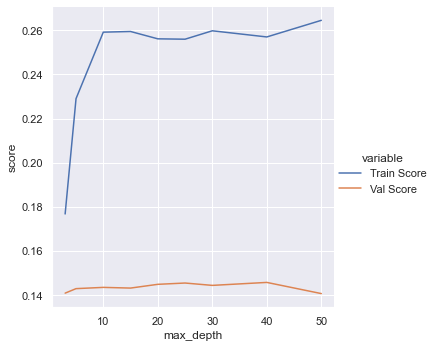

In [155]:
param = 'max_depth'
values = [3, 5, 10, 15, 20, 25, 30, 40, 50]
val_scores = []
train_scores = []
for v in tqdm(values):
    kw = {param: v}
    histr = HistGradientBoostingRegressor(max_iter=100, l2_regularization=1, **kw)
    histr.fit(x, y)
    val_scores.append(histr.score(val_x, val_y))
    train_scores.append(histr.score(x, y))

results = pd.DataFrame(zip(values, train_scores, val_scores), columns=[param, 'Train Score', 'Val Score'])
results_tall = results.melt(id_vars=[param], value_vars=['Train Score', 'Val Score'], value_name='score')


display(sns.relplot(data=results_tall, x=param, y='score', hue='variable', kind='line'))

In [164]:
def tune(param, values):
    val_scores = []
    train_scores = []
    for v in tqdm(values):
        kw = {param: v}
        histr = HistGradientBoostingRegressor(max_iter=100, l2_regularization=1, **kw)
        histr.fit(x, y)
        val_scores.append(histr.score(val_x, val_y))
        train_scores.append(histr.score(x, y))
        print(f'Val: {val_scores[-1]}. Train: {train_scores[-1]}')

    results = pd.DataFrame(zip(values, train_scores, val_scores), columns=[param, 'Train Score', 'Val Score'])
    results_tall = results.melt(id_vars=[param], value_vars=['Train Score', 'Val Score'], value_name='score')


    display(sns.relplot(data=results_tall, x=param, y='score', hue='variable', kind='line'))
    return results

100%|█████████████████████████████████████████████| 4/4 [04:55<00:00, 73.97s/it]


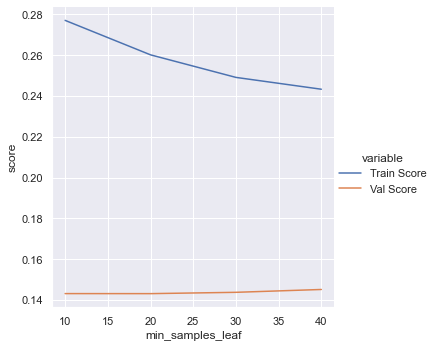

In [159]:
min_samples_leaf_results = tune('min_samples_leaf', [10, 20, 30, 40])

100%|█████████████████████████████████████████████| 4/4 [04:59<00:00, 74.84s/it]


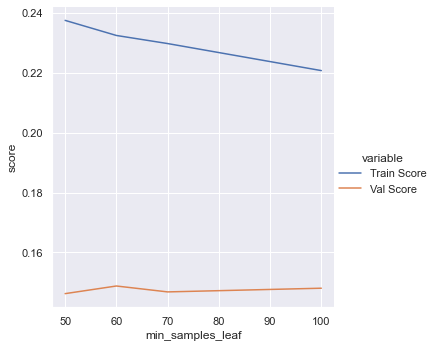

In [160]:
min_samples_leaf_results = tune('min_samples_leaf', [50, 60, 70, 100])

100%|███████████████████████████████████████████| 10/10 [08:56<00:00, 53.63s/it]


CPU times: user 51min 30s, sys: 3min 7s, total: 54min 37s
Wall time: 8min 56s


,learning_rate,Train Score,Val Score
0,0.1,0.258385,0.143969
1,0.2,0.297366,0.139277
2,0.3,0.316995,0.121061
3,0.4,0.298436,0.115828
4,0.5,0.293641,0.098714
5,0.6,0.270819,0.109283
6,0.7,0.287519,0.086900
7,0.8,0.248150,0.093622
8,0.9,0.235001,0.078597
9,1.0,0.231012,0.081570


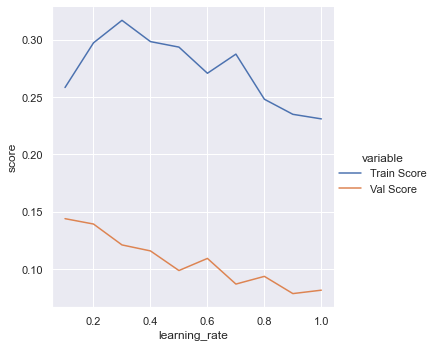

In [162]:
%%time
tune('learning_rate', np.arange(0.1, 1.1, .1))

 11%|█████                                        | 1/9 [01:22<11:02, 82.87s/it]

Val: 0.10154654769369176. Train: 0.12449562924570978


 22%|██████████                                   | 2/9 [02:51<10:02, 86.08s/it]

Val: 0.12855334368348836. Train: 0.16820062840908556


 33%|███████████████                              | 3/9 [04:10<08:18, 83.04s/it]

Val: 0.13753772484260862. Train: 0.19079092052630986


 44%|████████████████████                         | 4/9 [05:28<06:45, 81.01s/it]

Val: 0.14288250422280402. Train: 0.2045648855219383


 56%|█████████████████████████                    | 5/9 [06:49<05:23, 80.90s/it]

Val: 0.14303643805965438. Train: 0.22110309746659662


 67%|██████████████████████████████               | 6/9 [08:01<03:54, 78.12s/it]

Val: 0.14335692781726195. Train: 0.23415654730255486


 78%|███████████████████████████████████          | 7/9 [09:14<02:32, 76.39s/it]

Val: 0.143445225608836. Train: 0.24056443188869525


 89%|████████████████████████████████████████     | 8/9 [10:26<01:14, 74.84s/it]

Val: 0.14284710304525916. Train: 0.24393386166948894


100%|█████████████████████████████████████████████| 9/9 [11:36<00:00, 77.39s/it]

Val: 0.14557772511710088. Train: 0.25327811341506157


CPU times: user 1h 33min 19s, sys: 4min 37s, total: 1h 37min 57s
Wall time: 11min 36s


,learning_rate,Train Score,Val Score
0,0.01,0.124496,0.101547
1,0.02,0.168201,0.128553
2,0.03,0.190791,0.137538
3,0.04,0.204565,0.142883
4,0.05,0.221103,0.143036
5,0.06,0.234157,0.143357
6,0.07,0.240564,0.143445
7,0.08,0.243934,0.142847
8,0.09,0.253278,0.145578


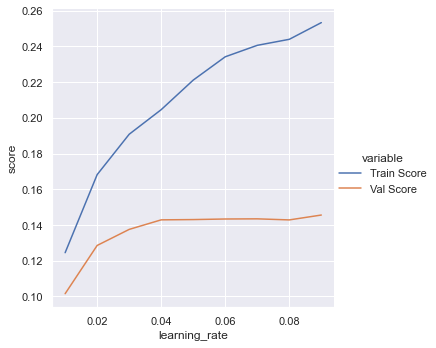

In [167]:
%%time
tune('learning_rate', np.arange(0.01, 0.1, .01))

### Best Hyperparams

In [198]:
%%time
histr = HistGradientBoostingRegressor(
    max_iter=100,
    max_depth=40,
    l2_regularization=2,
    min_samples_leaf=60,
    learning_rate=0.1
)
histr.fit(x, y)
histr.score(x, y), histr.score(val_x, val_y)

CPU times: user 9min 33s, sys: 32.4 s, total: 10min 6s
Wall time: 1min 12s


(0.2322340793102241, 0.1451134785312963)

### DDOS vs DDOS + TC

In [238]:
non_tc_cols = [c for c in x.columns if '_tc_' not in c]
non_ddos_cols = [c for c in x.columns if '_ddos_' not in c]
non_ddos_tc_cols = [c for c in x.columns if '_ddos_' not in c and '_tc_' not in c]

In [239]:
%%time
display(x[non_tc_cols].head())
histr = HistGradientBoostingRegressor()
histr.fit(x[non_tc_cols], y)
histr.score(x[non_tc_cols], y), histr.score(val_x[non_tc_cols], val_y)

,ip_ddos_0,er_ddos_0,out_ddos_0,snf_ddos_0,icf_ddos_0,hh_ddos_0,amb_ddos_0,hsp_ddos_0,pro_ddos_0,spc_fac_ddos_0,dme_ddos_0,cls_ddos_0,hha_ddos_0,ip_ddos_1,er_ddos_1,out_ddos_1,snf_ddos_1,icf_ddos_1,hh_ddos_1,amb_ddos_1,hsp_ddos_1,pro_ddos_1,spc_fac_ddos_1,dme_ddos_1,cls_ddos_1,hha_ddos_1,ip_ddos_2,er_ddos_2,out_ddos_2,snf_ddos_2,icf_ddos_2,hh_ddos_2,amb_ddos_2,hsp_ddos_2,pro_ddos_2,spc_fac_ddos_2,dme_ddos_2,cls_ddos_2,hha_ddos_2,ip_ddos_3,er_ddos_3,out_ddos_3,snf_ddos_3,icf_ddos_3,hh_ddos_3,amb_ddos_3,hsp_ddos_3,pro_ddos_3,spc_fac_ddos_3,dme_ddos_3,cls_ddos_3,hha_ddos_3,ip_ddos_4,er_ddos_4,out_ddos_4,snf_ddos_4,icf_ddos_4,hh_ddos_4,amb_ddos_4,hsp_ddos_4,pro_ddos_4,spc_fac_ddos_4,dme_ddos_4,cls_ddos_4,hha_ddos_4,ip_ddos_5,er_ddos_5,out_ddos_5,snf_ddos_5,icf_ddos_5,hh_ddos_5,amb_ddos_5,hsp_ddos_5,pro_ddos_5,spc_fac_ddos_5,dme_ddos_5,cls_ddos_5,hha_ddos_5,ip_ddos_6,er_ddos_6,out_ddos_6,snf_ddos_6,icf_ddos_6,hh_ddos_6,amb_ddos_6,hsp_ddos_6,pro_ddos_6,spc_fac_ddos_6,dme_ddos_6,cls_ddos_6,hha_ddos_6,ip_ddos_7,er_ddos_7,out_ddos_7,snf_ddos_7,icf_ddos_7,hh_ddos_7,amb_ddos_7,hsp_ddos_7,pro_ddos_7,spc_fac_ddos_7,dme_ddos_7,cls_ddos_7,hha_ddos_7,ip_ddos_8,er_ddos_8,out_ddos_8,snf_ddos_8,icf_ddos_8,hh_ddos_8,amb_ddos_8,hsp_ddos_8,pro_ddos_8,spc_fac_ddos_8,dme_ddos_8,cls_ddos_8,hha_ddos_8,ip_ddos_9,er_ddos_9,out_ddos_9,snf_ddos_9,icf_ddos_9,hh_ddos_9,amb_ddos_9,hsp_ddos_9,pro_ddos_9,spc_fac_ddos_9,dme_ddos_9,cls_ddos_9,hha_ddos_9,ip_ddos_10,er_ddos_10,out_ddos_10,snf_ddos_10,icf_ddos_10,hh_ddos_10,amb_ddos_10,hsp_ddos_10,pro_ddos_10,spc_fac_ddos_10,dme_ddos_10,cls_ddos_10,hha_ddos_10,ip_ddos_11,er_ddos_11,out_ddos_11,snf_ddos_11,icf_ddos_11,hh_ddos_11,amb_ddos_11,hsp_ddos_11,pro_ddos_11,spc_fac_ddos_11,dme_ddos_11,cls_ddos_11,hha_ddos_11,is_state_TN,is_state_FL,is_state_TX,is_state_KS,is_state_IA,is_lob_1,is_lob_3,is_lob_2,is_lob_8,is_group_0.0,is_group_3.0,is_group_2.0,is_group_1.0,is_group_-1.0,is_group_5.0,is_group_6.0,is_group_4.0,is_group_8.0,is_group_14.0,is_group_16.0,is_group_7.0,is_group_11.0,is_group_15.0,is_group_20.0,is_group_12.0,is_group_13.0,is_group_9.0,is_group_21.0,is_group_18.0,is_group_10.0,is_male,age
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,482.60,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,35.0
1,0.0,0.0,2.0,0.0,0.0,0.0,13.0,0.0,2.0,0.0,11.0,0.0,0.0,622.72,29.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393.88,0.0,0.0,4413.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,7.0,0.0,3.0,0.0,12.0,0.0,0.0,578.24,29.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1275.7,0.0,0.0,5813.68,1189.06,1189.06,1279.24,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,9.0,0.0,8.0,0.0,7.0,0.0,0.0,644.96,118.61,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.64,0.0,0.0,4930.47,0.0,0.0,1448.37,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.00,0.00,1214.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0

CPU times: user 3min 26s, sys: 9.65 s, total: 3min 36s
Wall time: 22.2 s


(0.15218079465324585, 0.048583478876227826)

In [240]:
%%time
display(x[non_ddos_cols].head())
histr = HistGradientBoostingRegressor()
histr.fit(x[non_ddos_cols], y)
histr.score(x[non_ddos_cols], y), histr.score(val_x[non_ddos_cols], val_y)

,hcbs_attdpcs_tc_0,hcbs_other_tc_0,hcbs_support_house_tc_0,hcbs_adult_day_tc_0,hcbs_pers_tc_0,hcbs_assist_tech_tc_0,oxygen_tc_0,hosp_bed_tc_0,chf_tc_0,heart_tc_0,copd_tc_0,pulmonar_tc_0,cancer_tc_0,ckd_tc_0,esrd_tc_0,lipidy_tc_0,diab_tc_0,alzh_tc_0,demented_tc_0,stroke_tc_0,hyper_tc_0,fall_tc_0,trans_tc_0,liver_tc_0,hippy_tc_0,depressed_tc_0,psycho_tc_0,druggy_tc_0,boozy_tc_0,paralyzed_tc_0,mono_tc_0,mono_dom_tc_0,hemi_tc_0,hemi_dom_tc_0,para_tc_0,quad_tc_0,tbi_tc_0,obese_tc_0,pressure_ulcer_tc_0,hemophilia_tc_0,hcbs_attdpcs_tc_1,hcbs_other_tc_1,hcbs_support_house_tc_1,hcbs_adult_day_tc_1,hcbs_pers_tc_1,hcbs_assist_tech_tc_1,oxygen_tc_1,hosp_bed_tc_1,chf_tc_1,heart_tc_1,copd_tc_1,pulmonar_tc_1,cancer_tc_1,ckd_tc_1,esrd_tc_1,lipidy_tc_1,diab_tc_1,alzh_tc_1,demented_tc_1,stroke_tc_1,hyper_tc_1,fall_tc_1,trans_tc_1,liver_tc_1,hippy_tc_1,depressed_tc_1,psycho_tc_1,druggy_tc_1,boozy_tc_1,paralyzed_tc_1,mono_tc_1,mono_dom_tc_1,hemi_tc_1,hemi_dom_tc_1,para_tc_1,quad_tc_1,tbi_tc_1,obese_tc_1,pressure_ulcer_tc_1,hemophilia_tc_1,hcbs_attdpcs_tc_2,hcbs_other_tc_2,hcbs_support_house_tc_2,hcbs_adult_day_tc_2,hcbs_pers_tc_2,hcbs_assist_tech_tc_2,oxygen_tc_2,hosp_bed_tc_2,chf_tc_2,heart_tc_2,copd_tc_2,pulmonar_tc_2,cancer_tc_2,ckd_tc_2,esrd_tc_2,lipidy_tc_2,diab_tc_2,alzh_tc_2,demented_tc_2,stroke_tc_2,hyper_tc_2,fall_tc_2,trans_tc_2,liver_tc_2,hippy_tc_2,depressed_tc_2,psycho_tc_2,druggy_tc_2,boozy_tc_2,paralyzed_tc_2,mono_tc_2,mono_dom_tc_2,hemi_tc_2,hemi_dom_tc_2,para_tc_2,quad_tc_2,tbi_tc_2,obese_tc_2,pressure_ulcer_tc_2,hemophilia_tc_2,hcbs_attdpcs_tc_3,hcbs_other_tc_3,hcbs_support_house_tc_3,hcbs_adult_day_tc_3,hcbs_pers_tc_3,hcbs_assist_tech_tc_3,oxygen_tc_3,hosp_bed_tc_3,chf_tc_3,heart_tc_3,copd_tc_3,pulmonar_tc_3,cancer_tc_3,ckd_tc_3,esrd_tc_3,lipidy_tc_3,diab_tc_3,alzh_tc_3,demented_tc_3,stroke_tc_3,hyper_tc_3,fall_tc_3,trans_tc_3,liver_tc_3,hippy_tc_3,depressed_tc_3,psycho_tc_3,druggy_tc_3,boozy_tc_3,paralyzed_tc_3,mono_tc_3,mono_dom_tc_3,hemi_tc_3,hemi_dom_tc_3,para_tc_3,quad_tc_3,tbi_tc_3,obese_tc_3,pressure_ulcer_tc_3,hemophilia_tc_3,hcbs_attdpcs_tc_4,hcbs_other_tc_4,hcbs_support_house_tc_4,hcbs_adult_day_tc_4,hcbs_pers_tc_4,hcbs_assist_tech_tc_4,oxygen_tc_4,hosp_bed_tc_4,chf_tc_4,heart_tc_4,copd_tc_4,pulmonar_tc_4,cancer_tc_4,ckd_tc_4,esrd_tc_4,lipidy_tc_4,diab_tc_4,alzh_tc_4,demented_tc_4,stroke_tc_4,hyper_tc_4,fall_tc_4,trans_tc_4,liver_tc_4,hippy_tc_4,depressed_tc_4,psycho_tc_4,druggy_tc_4,boozy_tc_4,paralyzed_tc_4,mono_tc_4,mono_dom_tc_4,hemi_tc_4,hemi_dom_tc_4,para_tc_4,quad_tc_4,tbi_tc_4,obese_tc_4,pressure_ulcer_tc_4,hemophilia_tc_4,hcbs_attdpcs_tc_5,hcbs_other_tc_5,hcbs_support_house_tc_5,hcbs_adult_day_tc_5,hcbs_pers_tc_5,hcbs_assist_tech_tc_5,oxygen_tc_5,hosp_bed_tc_5,chf_tc_5,heart_tc_5,copd_tc_5,pulmonar_tc_5,cancer_tc_5,ckd_tc_5,esrd_tc_5,lipidy_tc_5,diab_tc_5,alzh_tc_5,demented_tc_5,stroke_tc_5,hyper_tc_5,fall_tc_5,trans_tc_5,liver_tc_5,hippy_tc_5,depressed_tc_5,psycho_tc_5,druggy_tc_5,boozy_tc_5,paralyzed_tc_5,mono_tc_5,mono_dom_tc_5,hemi_tc_5,hemi_dom_tc_5,para_tc_5,quad_tc_5,tbi_tc_5,obese_tc_5,pressure_ulcer_tc_5,hemophilia_tc_5,hcbs_attdpcs_tc_6,hcbs_other_tc_6,hcbs_support_house_tc_6,hcbs_adult_day_tc_6,hcbs_pers_tc_6,hcbs_assist_tech_tc_6,oxygen_tc_6,hosp_bed_tc_6,chf_tc_6,heart_tc_6,...,trans_tc_6,liver_tc_6,hippy_tc_6,depressed_tc_6,psycho_tc_6,druggy_tc_6,boozy_tc_6,paralyzed_tc_6,mono_tc_6,mono_dom_tc_6,hemi_tc_6,hemi_dom_tc_6,para_tc_6,quad_tc_6,tbi_tc_6,obese_tc_6,pressure_ulcer_tc_6,hemophilia_tc_6,hcbs_attdpcs_tc_7,hcbs_other_tc_7,hcbs_support_house_tc_7,hcbs_adult_day_tc_7,hcbs_pers_tc_7,hcbs_assist_tech_tc_7,oxygen_tc_7,hosp_bed_tc_7,chf_tc_7,heart_tc_7,copd_tc_7,pulmonar_tc_7,cancer_tc_7,ckd_tc_7,esrd_tc_7,lipidy_tc_7,diab_tc_7,alzh_tc_7,demented_tc_7,stroke_tc_7,hyper_tc_7,fall_tc_7,trans_tc_7,liver_tc_7,hippy_tc_7,depressed_tc_7,psycho_tc_7,druggy_tc_7,boozy_tc_7,paralyzed_tc_7,mono_tc_7,mono_dom_tc_7,hemi_tc_7,hemi_dom_tc_7,para_tc_7,quad_tc_7,tbi_tc_7,obese_tc_7,pressure_ulcer_tc_7,hemophili

CPU times: user 7min 26s, sys: 25.6 s, total: 7min 52s
Wall time: 57.7 s


(0.2551991670830913, 0.14080755051147398)

In [241]:
%%time
display(x[non_ddos_tc_cols].head())
histr = HistGradientBoostingRegressor()
histr.fit(x[non_ddos_tc_cols], y)
histr.score(x[non_ddos_tc_cols], y), histr.score(val_x[non_ddos_tc_cols], val_y)

,is_state_TN,is_state_FL,is_state_TX,is_state_KS,is_state_IA,is_lob_1,is_lob_3,is_lob_2,is_lob_8,is_group_0.0,is_group_3.0,is_group_2.0,is_group_1.0,is_group_-1.0,is_group_5.0,is_group_6.0,is_group_4.0,is_group_8.0,is_group_14.0,is_group_16.0,is_group_7.0,is_group_11.0,is_group_15.0,is_group_20.0,is_group_12.0,is_group_13.0,is_group_9.0,is_group_21.0,is_group_18.0,is_group_10.0,is_male,age
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,35.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0


CPU times: user 2min 2s, sys: 8.11 s, total: 2min 10s
Wall time: 9.95 s


(0.03183516327097291, 0.005362494407857188)

In [218]:
%%time
histr = HistGradientBoostingRegressor()
histr.fit(x, y)
histr.score(x, y), histr.score(val_x, val_y)

CPU times: user 8min 50s, sys: 21.9 s, total: 9min 12s
Wall time: 1min 4s


(0.2580479554452283, 0.13860533237776884)

In [221]:
%%time
histr = Ridge(normalize=True)
histr.fit(x[non_tc_cols], y)
histr.score(x[non_tc_cols], y), histr.score(val_x[non_tc_cols], val_y)

CPU times: user 5.44 s, sys: 1.78 s, total: 7.22 s
Wall time: 2.86 s


(0.05674733142663391, 0.04700629596080885)

In [237]:
%%time
histr = Ridge(normalize=True)
histr.fit(x[non_ddos_cols], y)
histr.score(x[non_ddos_cols], y), histr.score(val_x[non_ddos_cols], val_y)

CPU times: user 15.5 s, sys: 4.42 s, total: 19.9 s
Wall time: 8.97 s


(0.1413362264947048, 0.1370474189798191)

In [222]:
%%time
histr = Ridge(normalize=True)
histr.fit(x, y)
histr.score(x, y), histr.score(val_x, val_y)

CPU times: user 18.3 s, sys: 2.39 s, total: 20.7 s
Wall time: 6.24 s


(0.14424797162605385, 0.13751398796161485)

### Look at feature importances
Quick tune alpha's first

In [261]:
tc_col_roots = set([c.split('_tc_')[0] for c in x.columns if '_tc_' in c])
# tc_col_roots

In [269]:
# for c in tc_col_roots:
#     cs = [f'{c}_tc_{i}' for i in range(8, 12)]
#     df = train_df[cs + ['target']]
#     df = df.melt(id_vars=['target'])
#     ax = sns.relplot(data=df, x='target', y='value',col='variable')
# # ax.set_xlabel('target')
# # ax.set_ylabel(c + ' TC')
# # ax.set_title(c + ' TC');
#     plt.show()

In [270]:
# for c in tc_col_roots:
#     cs = [f'{c}_tc_{i}' for i in range(8, 12)]
#     df = train_df.loc[train_df.period >= 30][cs + ['target']]
#     df = df.melt(id_vars=['target'])
#     ax = sns.relplot(data=df, x='target', y='value',col='variable')
#     plt.show()

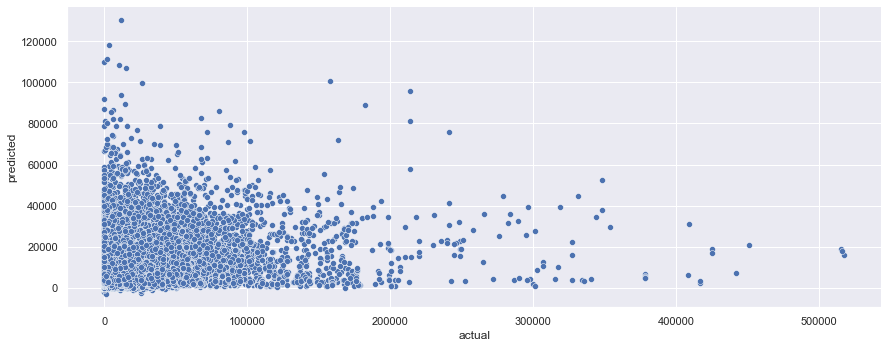

In [31]:
sns.relplot(data=actual_predicted_df, x="actual", y="predicted", height=5, aspect=2.5)

In [75]:
labels = [f"decile_{i}" for i in range(1, 11)]
actual_predicted_df = actual_predicted_df.assign(
    act_pct=actual_predicted_df.actual.rank(pct=True),
    pred_pct=actual_predicted_df.predicted.rank(pct=True)
)

actual_predicted_df = actual_predicted_df.assign(
    act_decile=pd.cut(actual_predicted_df.act_pct, 10, labels=labels),
    pred_decile=pd.cut(actual_predicted_df.pred_pct, 10, labels=labels)
)

In [76]:
actual_predicted_df.head()

,actual,predicted,abs_diff,act_decile,pred_decile,act_pct,pred_pct
0,614.88,2103.704325,1488.824325,decile_6,decile_5,0.701743,0.468401
1,20978.28,2837.965625,18140.314375,decile_10,decile_6,0.940827,0.598746
2,0.00,597.163115,597.163115,decile_1,decile_2,0.308827,0.139586
3,15808.90,20422.796984,4613.896984,decile_9,decile_10,0.922517,0.975789
4,1336.70,9615.297993,8278.597993,decile_7,decile_10,0.761709,0.900345


In [77]:
display(actual_predicted_df.act_decile.value_counts())
actual_predicted_df.pred_decile.value_counts()

decile_1     90743
decile_8     10157
decile_7     10155
decile_10    10155
decile_6     10152
decile_9     10152
decile_5      5403
decile_2         0
decile_3         0
decile_4         0
Name: act_decile, dtype: int64

decile_2     14939
decile_3     14693
decile_5     14692
decile_7     14692
decile_9     14692
decile_10    14692
decile_4     14691
decile_6     14691
decile_8     14691
decile_1     14444
Name: pred_decile, dtype: int64

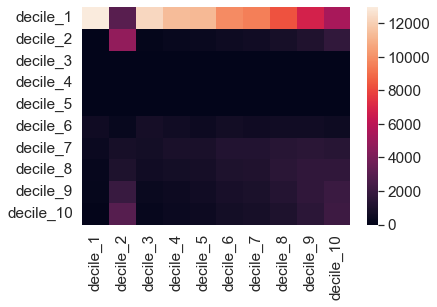

In [78]:
from sklearn.metrics import confusion_matrix
cm_array = confusion_matrix(actual_predicted_df.act_decile, actual_predicted_df.pred_decile)
df_cm = pd.DataFrame(cm_array, labels, labels)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm) # font size

plt.show()

### Feature importance

In [32]:
sorted(zip(ridge.coef_, x.columns))

[(-773.8248911073543, 'is_group_10.0'),
 (-719.7832852099407, 'is_group_14.0'),
 (-551.5794726910301, 'is_group_16.0'),
 (-539.3535405895841, 'is_group_7.0'),
 (-490.8716292362635, 'is_group_15.0'),
 (-455.4624060162455, 'is_group_9.0'),
 (-420.02022789740226, 'is_group_12.0'),
 (-411.6450916790314, 'is_lob_1'),
 (-410.02508942825364, 'is_group_18.0'),
 (-386.36203378725094, 'is_group_8.0'),
 (-385.63874522516306, 'is_state_IA'),
 (-346.6747329392493, 'is_group_4.0'),
 (-337.3477164364633, 'hemi_dom_tc_2'),
 (-313.17204164658074, 'hyper_tc_1'),
 (-312.7923514420944, 'is_group_6.0'),
 (-276.84528268353245, 'is_group_5.0'),
 (-274.4829203606444, 'oxygen_tc_4'),
 (-254.0283708992548, 'is_group_13.0'),
 (-230.2644345203826, 'hosp_bed_tc_0'),
 (-213.21873099586713, 'hsp_ddos_9'),
 (-211.14171756263963, 'fall_tc_0'),
 (-210.93142243826992, 'para_tc_1'),
 (-201.41270743237146, 'demented_tc_9'),
 (-200.78288097544947, 'stroke_tc_5'),
 (-198.0506277269043, 'amb_ddos_5'),
 (-192.2168691402412, '

In [266]:
from sklearn.inspection import permutation_importance

In [273]:
result = permutation_importance(histr, val_x, val_y, n_repeats=10,random_state=0, n_jobs=-1)

In [272]:
sorted(zip(result.importances_mean, val_x.columns))

[(-0.0007723196063331716, 'ip_ddos_1'),
 (-0.0007613080344119228, 'out_ddos_7'),
 (-0.0006213780445273765, 'pro_ddos_6'),
 (-0.0006040160463351762, 'dme_ddos_4'),
 (-0.0005426325574968028, 'out_ddos_4'),
 (-0.0005344473363957825, 'pro_ddos_4'),
 (-0.00042550598246204885, 'hh_ddos_0'),
 (-0.00041766603550545954, 'pro_ddos_8'),
 (-0.00039609842375647463, 'amb_ddos_0'),
 (-0.0003715464358559517, 'hh_ddos_10'),
 (-0.00036159888644871074, 'out_ddos_0'),
 (-0.00035674841632420405, 'amb_ddos_3'),
 (-0.0003384314455971538, 'dme_ddos_5'),
 (-0.0003093824656464017, 'er_ddos_0'),
 (-0.00029041345635669733, 'dme_ddos_6'),
 (-0.0002771600599830837, 'dme_ddos_10'),
 (-0.00027710314100239943, 'dme_ddos_0'),
 (-0.00022345737934712507, 'dme_ddos_7'),
 (-0.00021884647303249682, 'hh_ddos_6'),
 (-0.00021387650280220162, 'er_ddos_5'),
 (-0.00016166853624497435, 'out_ddos_1'),
 (-0.00015999504317887325, 'pro_ddos_5'),
 (-0.000155104495229752, 'out_ddos_9'),
 (-0.00014995055466715534, 'er_ddos_1'),
 (-0.0001

In [65]:
export_cols

['target',
 'ip_ddos',
 'er_ddos',
 'out_ddos',
 'snf_ddos',
 'icf_ddos',
 'hh_ddos',
 'amb_ddos',
 'hsp_ddos',
 'pro_ddos',
 'spc_fac_ddos',
 'dme_ddos',
 'cls_ddos',
 'hha_ddos',
 'is_anthem_tn',
 'is_uhc_tn',
 'is_uhc_fl',
 'is_uhc_tx',
 'is_uhc_ks',
 'is_anthem_ia',
 'is_ia_centene_itc',
 'is_lob_1',
 'is_lob_3',
 'is_lob_2',
 'is_lob_8',
 'is_group_0.0',
 'is_group_3.0',
 'is_group_2.0',
 'is_group_1.0',
 'is_group_-1.0',
 'is_group_5.0',
 'is_group_6.0',
 'is_group_4.0',
 'is_group_8.0',
 'is_group_14.0',
 'is_group_16.0',
 'is_group_7.0',
 'is_group_11.0',
 'is_group_15.0',
 'is_group_20.0',
 'is_group_12.0',
 'is_group_13.0',
 'is_group_9.0',
 'is_group_21.0',
 'is_group_18.0',
 'is_group_10.0',
 'is_male',
 'age']